In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.8 MB/s eta 0:00:00


In [ ]:
!pip install optuna optuna-integration[xgboost]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 5.1 MB/s eta 0:00:00


In [ ]:
!pip install category-encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.7 MB/s eta 0:00:00


In [116]:
import pandas as pd
import re
from sklearn.model_selection import KFold
from category_encoders import TargetEncoder
import numpy as np

# Load the dataset
df_original = pd.read_csv("HousingData_12March.csv")

# Convert relevant numeric columns
df_original["Area"] = df_original["Area"].str.extract(r"([\d.]+)").astype(float)
df_original["Balcony Area"] = df_original["Balcony Area"].str.extract(r"([\d.]+)").astype(float)
numeric_cols = ["ID", "Price", "Urban ID", "District ID", "Room Type ID",
                "Bedroom Type ID", "Condition ID", "Total Floors", "Floor", "Status", "Latitude", "Longitude"]
df_original[numeric_cols] = df_original[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Remove duplicates
df = df_original.drop_duplicates(subset=["ID", "Price"], keep="first").copy()

# Remove bad IDs
bad_IDs = [20576957, 17577023, 20695863, 20729510, 20723826, 19363467, 20646514, 20644095,20471009]
df = df[~df['ID'].isin(bad_IDs)][["ID", "Price", "Area", "District ID", "Urban ID",
                                  "Room Type ID", "Condition ID", "Status", "Bedroom Type ID",
                                  "Latitude", "Longitude"]]
df.dropna(inplace=True)

# Function for Target Encoding with Cross-Validation
def cross_val_target_encoding(df, cat_cols, target_col, n_splits=5):
    df = df.reset_index(drop=True)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype("category")
        else:
            print(f"Column {col} not found!")
            continue

        df["Encoded_" + col] = np.nan  # Placeholder for encoded values

        for train_idx, val_idx in kf.split(df):
            train_data, val_data = df.iloc[train_idx], df.iloc[val_idx]
            encoder = TargetEncoder()
            encoder.fit(train_data[[col]], train_data[target_col])
            df.loc[val_idx, "Encoded_" + col] = encoder.transform(val_data[[col]]).values.ravel()

        df.drop(columns=[col], inplace=True)
    return df

# Apply Target Encoding
cat_columns = ["District ID", "Urban ID", "Room Type ID", "Condition ID", "Status", "Bedroom Type ID"]
df = cross_val_target_encoding(df, cat_columns, "Price")

# Remove outliers using IQR
def remove_outliers_iqr(df, column, coeff=1.5):
    Q1, Q3 = df[column].quantile(0.25), df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - coeff * IQR) & (df[column] <= Q3 + coeff * IQR)]

df = remove_outliers_iqr(df, "Price")
df = remove_outliers_iqr(df, "Area")




In [117]:
df_original.columns

Index(['ID', 'Price', 'Currency_ID', 'Area', 'District Name', 'District ID',
       'Address', 'Urban Name', 'Urban ID', 'Condition ID', 'Room Type ID',
       'Bedroom Type ID', 'Bathroom Type ID', 'Floor', 'Total Floors',
       'Balconies', 'Balcony Area', 'Owner Name', 'User ID', 'User Type',
       'User Statements Count', 'Is VIP', 'Is VIP Plus', 'Is Super VIP',
       'Views', 'Published', 'Last Updated', 'Status', 'Longitude',
       'Latitude'],
      dtype='object')

[I 2025-03-12 13:56:07,865] A new study created in memory with name: no-name-4d1fa9ae-2aa3-44e2-ae4c-ec54414f81d8
[I 2025-03-12 13:56:11,897] Trial 0 finished with value: 11209.272300805793 and parameters: {'max_depth': 5, 'min_child_weight': 5, 'gamma': 0.1068384046732368, 'subsample': 0.7450613188079979, 'colsample_bytree': 0.8971361306056616, 'learning_rate': 0.01481763360192505, 'n_estimators': 168, 'reg_alpha': 0.7857043195090379, 'reg_lambda': 7.358498185449733}. Best is trial 0 with value: 11209.272300805793.
[I 2025-03-12 13:56:13,068] Trial 1 finished with value: 10637.827926464863 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.4726236372541163, 'subsample': 0.8725697907255747, 'colsample_bytree': 0.7727272968992112, 'learning_rate': 0.021960295370412795, 'n_estimators': 183, 'reg_alpha': 0.27669599366582276, 'reg_lambda': 5.936350268304393}. Best is trial 1 with value: 10637.827926464863.
[I 2025-03-12 13:56:16,877] Trial 2 finished with value: 10884.59768

Best Hyperparameters from Optuna: {'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.3608633233280329, 'subsample': 0.8134781459455006, 'colsample_bytree': 0.8530769462168457, 'learning_rate': 0.03813195600472803, 'n_estimators': 284, 'reg_alpha': 0.014920755792247747, 'reg_lambda': 0.6732502836973553}
Test RMSE: 10547.3976
              ID  Actual Price  Predicted Price
1403  20577108.0       64625.0     63538.527344
68    20397157.0      117000.0     91130.218750
716   19327322.0       78000.0     87146.312500
959   20668767.0       60000.0     69279.343750
1665  20502561.0       60000.0     57730.949219


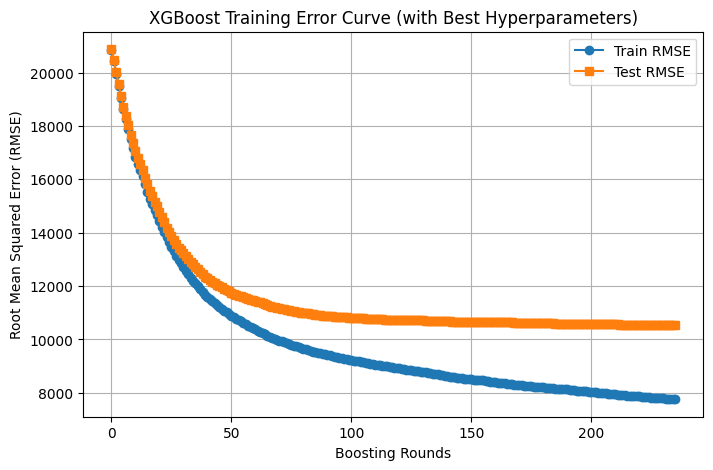

In [118]:
import optuna
from optuna.integration import XGBoostPruningCallback
import xgboost as xgb
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is already cleaned and processed as per previous steps
# Ensure that you have the 'ID' column extracted for tracking predictions
X, y = df.drop(columns=["Price"]), df["Price"]  # Exclude "ID" from features (X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Keep 'ID' for reference, separately
X_train_ids = df.loc[X_train.index, "ID"]
X_test_ids = df.loc[X_test.index, "ID"]

# Drop 'ID' from the training and testing data
X_train = X_train.drop(columns=["ID"])
X_test = X_test.drop(columns=["ID"])

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse", enable_categorical=True)

def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "gamma": trial.suggest_float("gamma", 0, 0.5),
        "subsample": trial.suggest_float("subsample", 0.7, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 0.9),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "objective": "reg:squarederror"
    }

    # Use K-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = xgb.XGBRegressor(**params)
    scores = cross_val_score(model, X, y, cv=kf, scoring="neg_root_mean_squared_error", n_jobs=-1)
    return -np.mean(scores)

# Optimize using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best parameters from Optuna
best_params = study.best_params
print("Best Hyperparameters from Optuna:", best_params)

# Convert data to DMatrix for evaluation tracking
train_dmatrix = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
test_dmatrix = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Train final model with best parameters and evaluation tracking
evals_result = {}
best_model = xgb.train(
    best_params,
    train_dmatrix,
    num_boost_round=best_params["n_estimators"],
    evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],
    evals_result=evals_result,
    early_stopping_rounds=10,
    verbose_eval=False
)

# Predict on test set
y_pred = best_model.predict(test_dmatrix)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {test_rmse:.4f}")

# Create a DataFrame with predictions and their corresponding IDs
predictions_df = pd.DataFrame({
    "ID": X_test_ids,
    "Actual Price": y_test,
    "Predicted Price": y_pred
})

# Display the predictions with IDs for reference
print(predictions_df.head())

# Extract training and validation errors
train_errors = evals_result['train']['rmse']
test_errors = evals_result['test']['rmse']

# Plot error curves
plt.figure(figsize=(8, 5))
plt.plot(range(len(train_errors)), train_errors, label="Train RMSE", marker='o')
plt.plot(range(len(test_errors)), test_errors, label="Test RMSE", marker='s')
plt.xlabel("Boosting Rounds")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("XGBoost Training Error Curve (with Best Hyperparameters)")
plt.legend()
plt.grid()
plt.show()


In [119]:
importance_scores = best_model.get_score(importance_type='weight')  # Options: 'weight', 'gain', 'cover'

# Print feature importance
print(importance_scores)


{'Area': 745.0, 'Latitude': 497.0, 'Longitude': 568.0, 'Encoded_District ID': 182.0, 'Encoded_Urban ID': 368.0, 'Encoded_Room Type ID': 213.0, 'Encoded_Condition ID': 385.0, 'Encoded_Status': 149.0, 'Encoded_Bedroom Type ID': 123.0}


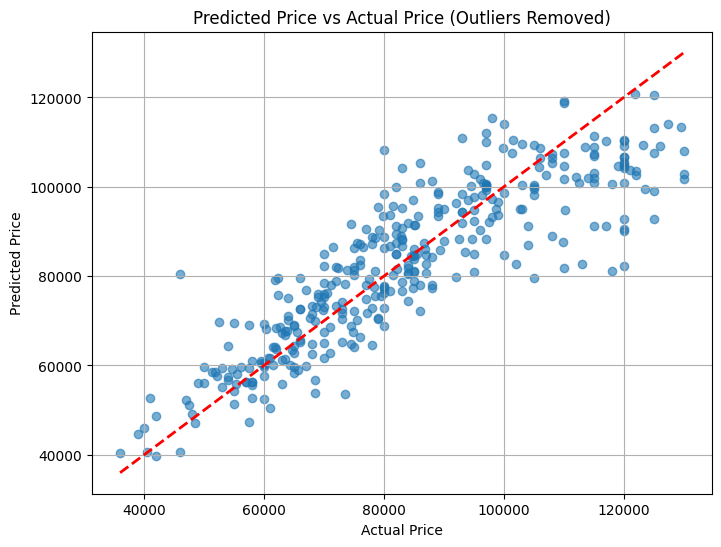

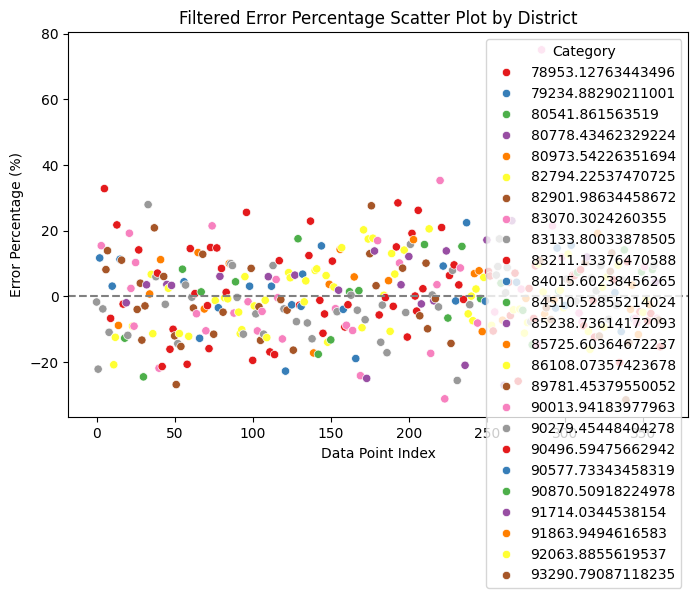

<ipython-input-120-1fa564db2d94>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Category", y="Error Percentage", data=df_filtered, palette="Set2")


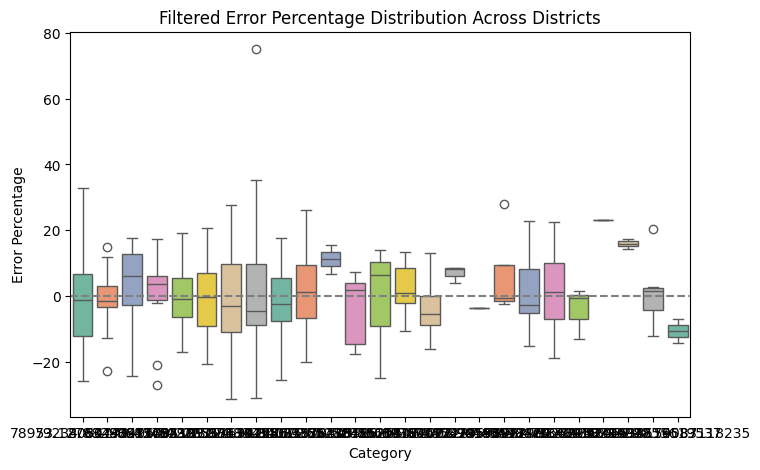

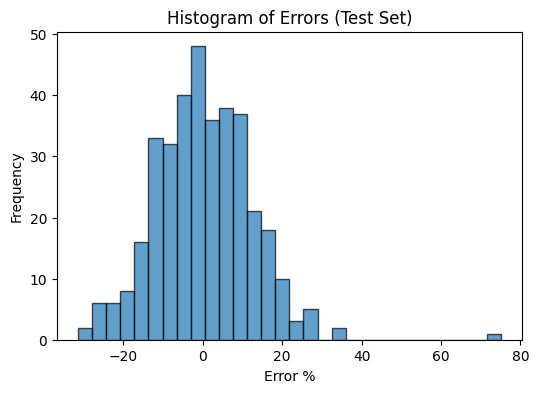

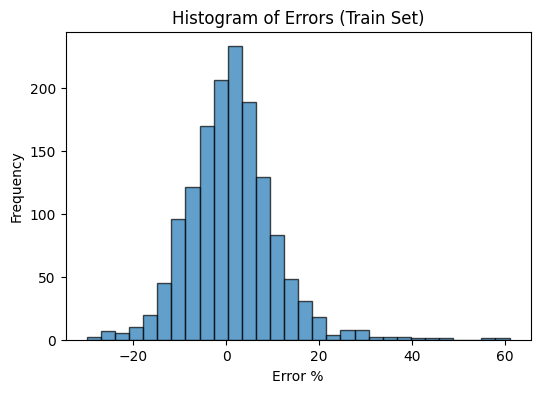

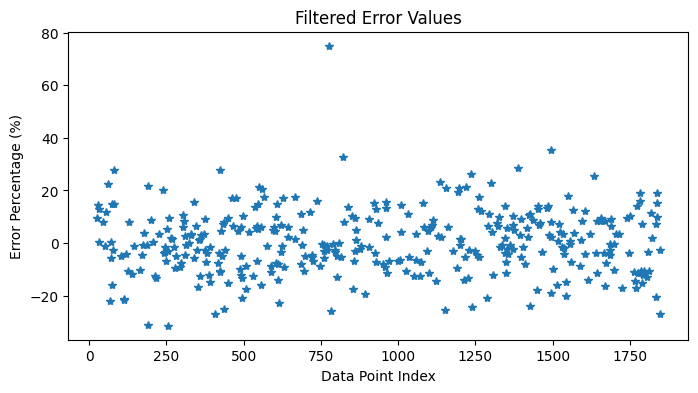

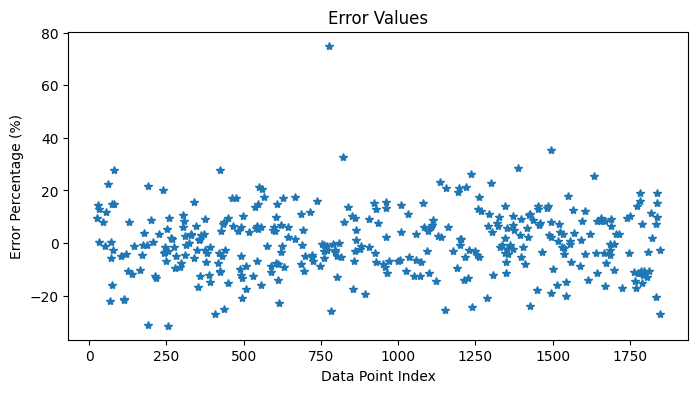

In [120]:
# Filter outliers function
def filter_outliers(data, lower_percentile=1, upper_percentile=99):
    """Removes outliers based on the given percentile range."""
    lower_bound = np.percentile(data, lower_percentile)
    upper_bound = np.percentile(data, upper_percentile)
    return (data >= lower_bound) & (data <= upper_bound)

# Scatter plot function
def plot_scatter(x, y, xlabel, ylabel, title):
    """Plots a scatter plot with a y=x reference line."""
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.6)
    plt.plot([min(x), max(x)], [min(x), max(x)], color='red', linestyle='dashed', linewidth=2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Categorical scatter plot function
def plot_categorical_scatter(data, categories, title):
    """Plots a scatter plot of error percentage by categories."""
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=range(len(data)), y=data, hue=categories, palette="Set1")
    plt.axhline(0, color='gray', linestyle='dashed')
    plt.xlabel("Data Point Index")
    plt.ylabel("Error Percentage (%)")
    plt.title(title)
    plt.legend(title="Category")
    plt.show()

# Boxplot function
def plot_boxplot(data, categories, title):
    """Plots a boxplot for error percentage distribution across categories."""
    df_filtered = pd.DataFrame({"Error Percentage": data, "Category": categories})
    plt.figure(figsize=(8, 5))
    sns.boxplot(x="Category", y="Error Percentage", data=df_filtered, palette="Set2")
    plt.axhline(0, color='gray', linestyle='dashed')
    plt.title(title)
    plt.show()

# Histogram function
def plot_histogram(data, xlabel, title):
    """Plots a histogram of error percentages."""
    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.title(title)
    plt.show()

# Compute Error Percentage
y_train_pred = best_model.predict(xgb.DMatrix(X_train, enable_categorical=True))  # Predict on train set
error_test = (y_pred - y_test) / y_test * 100
error_train = (y_train_pred - y_train) / y_train * 100

# Filter out outliers for error percentages
mask_test = filter_outliers(error_test, 0, 100)
mask_train = filter_outliers(error_train, 0, 100)

filtered_error_test = error_test[mask_test]
filtered_error_train = error_train[mask_train]

# Ensure the encoded columns exist before filtering them for plots
encoded_district_test = X_test.get("Encoded_District ID", None)
encoded_district_train = X_train.get("Encoded_District ID", None)

if encoded_district_test is not None and encoded_district_train is not None:
    # Filter categorical variables (using encoded columns)
    filtered_category_test = encoded_district_test[mask_test]
    filtered_category_train = encoded_district_train[mask_train]

    # Plot results
    plot_scatter(y_test[mask_test], y_pred[mask_test], "Actual Price", "Predicted Price",
                 "Predicted Price vs Actual Price (Outliers Removed)")
    plot_categorical_scatter(filtered_error_test, filtered_category_test,
                             "Filtered Error Percentage Scatter Plot by District")
    plot_boxplot(filtered_error_test, filtered_category_test,
                 "Filtered Error Percentage Distribution Across Districts")
    plot_histogram(filtered_error_test, "Error %", "Histogram of Errors (Test Set)")
    plot_histogram(filtered_error_train, "Error %", "Histogram of Errors (Train Set)")

    # Plot individual error values (filtered)
    plt.figure(figsize=(8, 4))
    plt.plot(filtered_error_test, "*")
    plt.xlabel("Data Point Index")
    plt.ylabel("Error Percentage (%)")
    plt.title("Filtered Error Values")
    plt.show()

    # Plot individual error values (unfiltered)
    plt.figure(figsize=(8, 4))
    plt.plot(error_test, "*")
    plt.xlabel("Data Point Index")
    plt.ylabel("Error Percentage (%)")
    plt.title("Error Values")
    plt.show()

else:
    print("Encoded columns 'Encoded_District ID' are not found in the data. Please ensure target encoding is applied correctly.")



In [121]:
# Compute Mean Percentage Error (MPE) for test and train data
mpe_test = np.mean(np.abs(error_test))
mpe_train = np.mean(np.abs(error_train))

print(f"Mean Percentage Error (Test Data): {mpe_test:.2f}%")
print(f"Mean Percentage Error (Train Data): {mpe_train:.2f}%")

Mean Percentage Error (Test Data): 9.44%
Mean Percentage Error (Train Data): 6.98%


In [122]:
def inspect_extreme_errors(y_true, y_pred, X, X_ids, threshold=50):
    """
    Identifies and returns data points where the absolute percentage error exceeds the threshold.

    Parameters:
        y_true (pd.Series or np.array): Actual values.
        y_pred (pd.Series or np.array): Predicted values.
        X (pd.DataFrame): Feature set corresponding to y_true (without 'ID' column).
        X_ids (pd.Series): Series containing 'ID' column.
        threshold (float): Error percentage threshold to identify extreme errors (default=50%).

    Returns:
        pd.DataFrame: DataFrame containing extreme error data points.
    """
    # Avoid division by zero
    y_true = np.where(y_true == 0, np.nan, y_true)  # Replace 0 with NaN to prevent divide-by-zero errors
    error_percentage = ((y_pred - y_true) / y_true) * 100

    # Identify extreme errors
    extreme_error_mask = np.abs(error_percentage) > threshold

    # Construct DataFrame for extreme errors
    extreme_errors_df = pd.DataFrame({
        "ID": X_ids[extreme_error_mask].values,  # Ensuring alignment
        "Actual Price": y_true[extreme_error_mask],
        "Predicted Price": y_pred[extreme_error_mask],
        "Error Percentage": error_percentage[extreme_error_mask]
    }).reset_index(drop=True)

    # Join features for identified extreme errors
    return extreme_errors_df.join(X.loc[extreme_error_mask].reset_index(drop=True))


# Example Usage:
extreme_errors = inspect_extreme_errors(y_test, y_pred, X_test, X_test_ids, threshold=30)


def get_extreme_error_original_data(extreme_errors_df, original_df):
    """
    Matches extreme error data points with the original dataset using 'ID' column
    and appends predicted prices and error percentages.

    Parameters:
        extreme_errors_df (pd.DataFrame): DataFrame containing extreme errors (must have 'ID' column).
        original_df (pd.DataFrame): The full original dataset.

    Returns:
        pd.DataFrame: Matching rows from the original dataset with Predicted Price and Error Percentage added.
    """
    # Merge original data with extreme error data based on 'ID'
    matched_data = original_df.merge(extreme_errors_df, on="ID", how="inner")

    return matched_data


# Example Usage:
extreme_error_original_data = get_extreme_error_original_data(extreme_errors, df_original)

# Display selected columns from extreme error cases
cols_to_display = ["ID", "Actual Price", "Predicted Price", "Error Percentage",
                   "Area_y", "Latitude_y", "Longitude_y",
                   "District ID", "Urban ID", "Room Type ID", "Condition ID", "Status",
                   "Bedroom Type ID"]

extreme_error_original_data[cols_to_display].head()


,ID,Actual Price,Predicted Price,Error Percentage,Area_y,Latitude_y,Longitude_y,District ID,Urban ID,Room Type ID,Condition ID,Status,Bedroom Type ID
0,20520187.0,118000.0,81238.242188,-31.154032,50.0,41.743070,44.722410,4.0,43.0,2.0,1.0,2.0,1.0
1,18541817.0,120000.0,82252.468750,-31.456276,55.7,41.713389,44.756228,4.0,38.0,2.0,5.0,3.0,1.0
2,20471009.0,46000.0,80533.304688,75.072401,40.0,41.720732,44.709300,4.0,47.0,2.0,1.0,2.0,1.0
3,18049657.0,52500.0,69738.078125,32.834435,39.0,41.708692,44.787526,5.0,53.0,2.0,1.0,2.0,1.0
4,18457204.0,80000.0,108241.898438,35.302373,58.0,41.718086,44.707071,4.0,47.0,2.0,1.0,2.0,1.0
